# Local-Global-Trend(LGT) Example

In [70]:
import pandas as pd
import numpy as np
from orbit.lgt import LGT
from orbit.utils.utils import plot_predicted_data

## Data

In [71]:
DATA_FILE = "./data/iclaims.example.csv"
DATA_FILE = "./data/problem_data.csv"

In [72]:
raw_df = pd.read_csv(DATA_FILE, parse_dates=['date'])

In [73]:
raw_df.dtypes

key                 object
week_num             int64
value              float64
date        datetime64[ns]
dtype: object

In [74]:
raw_df.head(5)

,key,week_num,value,date
0,W10,2,246.98,1970-01-05
1,W10,3,222.30,1970-01-12
2,W10,4,449.98,1970-01-19
3,W10,5,449.98,1970-01-26
4,W10,6,449.98,1970-02-02


In [75]:
DATE_COL="date"
RESPONSE_COL="value"

### Data Transformation

In [76]:
# df=raw_df.copy()
# df2=raw_df.copy()
# df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] = \
#     df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log, axis=1)
# df.head(5)

In [77]:
df=raw_df.copy()
df2=raw_df.copy()
df[['value']] = \
    df[['value']].apply(np.log, axis=1)
df.head(5)

,key,week_num,value,date
0,W10,2,5.509307,1970-01-05
1,W10,3,5.404028,1970-01-12
2,W10,4,6.109203,1970-01-19
3,W10,5,6.109203,1970-01-26
4,W10,6,6.109203,1970-02-02


### Train / Test Split

In [53]:
test_size=13
train_df=df[:-test_size]

# in uTS we make assertion that test dates need to be between train start/end
test_df=df[-test_size:]

In [78]:
test_size=13
train_df2=df2[:-test_size]

# in uTS we make assertion that test dates need to be between train start/end
test_df2=df2[-test_size:]

In [79]:
train_df2.head(5)

,key,week_num,value,date
0,W10,2,246.98,1970-01-05
1,W10,3,222.30,1970-01-12
2,W10,4,449.98,1970-01-19
3,W10,5,449.98,1970-01-26
4,W10,6,449.98,1970-02-02


In [80]:
test_df2.tail(5)

,key,week_num,value,date
929,W10,931,5137.97,1987-10-26
930,W10,932,5122.14,1987-11-02
931,W10,933,5122.14,1987-11-09
932,W10,934,5122.14,1987-11-16
933,W10,935,5122.14,1987-11-23


In [57]:
train_df.head(5)

,key,week_num,value,date
0,W10,2,5.509307,1970-01-05
1,W10,3,5.404028,1970-01-12
2,W10,4,6.109203,1970-01-19
3,W10,5,6.109203,1970-01-26
4,W10,6,6.109203,1970-02-02


## MAP Fit and Predict

In [58]:
lgt_map=LGT(
    response_col=RESPONSE_COL,
    date_col=DATE_COL,
    seasonality=52,
    seed=8888,
    predict_method='map',
    is_rescale=False,
    is_multiplicative=False
)

In [59]:
lgt_map2=LGT(
    response_col=RESPONSE_COL,
    date_col=DATE_COL,
    seasonality=52,
    seed=8888,
    predict_method='map',
    is_rescale=False
)

In [60]:
lgt_map.fit(df=train_df)

In [61]:
lgt_map2.fit(df=train_df2)

In [62]:
lgt_map.df.head(5)

,key,week_num,value,date
0,W10,2,5.509307,1970-01-05
1,W10,3,5.404028,1970-01-12
2,W10,4,6.109203,1970-01-19
3,W10,5,6.109203,1970-01-26
4,W10,6,6.109203,1970-02-02


In [63]:
lgt_map2.df.head(5)

,key,week_num,value,date
0,W10,2,5.509307,1970-01-05
1,W10,3,5.404028,1970-01-12
2,W10,4,6.109203,1970-01-19
3,W10,5,6.109203,1970-01-26
4,W10,6,6.109203,1970-02-02


In [64]:
predicted_df = lgt_map.predict(df=test_df)

In [65]:
predicted_df['prediction']=predicted_df['prediction'].apply(np.exp)
predicted_df.head(5)

,date,prediction
0,1987-08-31,4837.289455
1,1987-09-07,4831.801959
2,1987-09-14,4819.337734
3,1987-09-21,4817.598294
4,1987-09-28,4816.137576


In [66]:
predicted_df2 = lgt_map2.predict(df=test_df2)
predicted_df2.head(5)

,date,prediction
0,1987-08-31,4837.289455
1,1987-09-07,4831.801959
2,1987-09-14,4819.337734
3,1987-09-21,4817.598294
4,1987-09-28,4816.137576


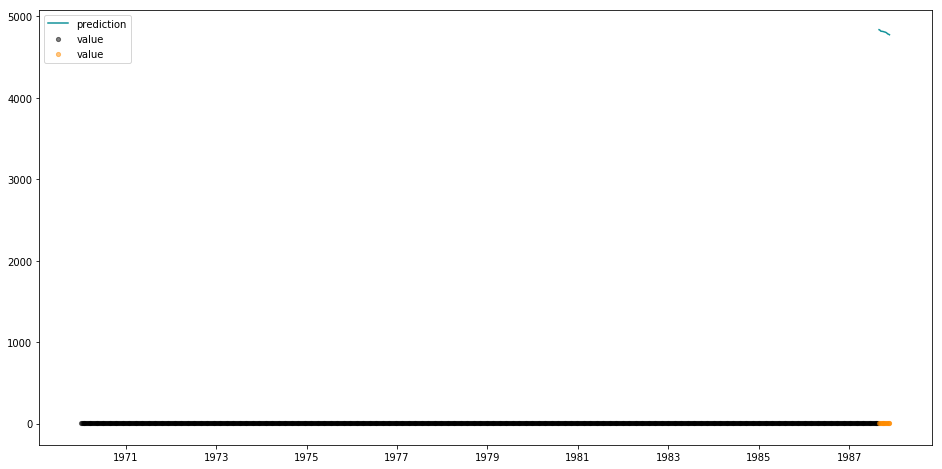

In [69]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_map.date_col, actual_col=lgt_map.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

In [ ]:
test_df.head(5)

## MCMC Fit and Predict

In [ ]:
lgt_mcmc = LGT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    num_warmup=4000, 
    num_sample=500,
    sample_method='mcmc',
    predict_method='full',
    n_bootstrap_draws=500
)

In [ ]:
lgt_mcmc.fit(df=train_df)

In [ ]:
predicted_df = lgt_mcmc.predict(df=test_df)

In [ ]:
predicted_df.tail(5)

In [ ]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_mcmc.date_col, actual_col=lgt_mcmc.response_col, pred_col=50, 
                    pred_quantiles_col=[5,95], test_actual_df=test_df)

## Mean Fit and Predict Decomp

In [ ]:
lgt_mean=LGT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    predict_method='mean'
)

In [ ]:
lgt_mean.fit(df=train_df)

In [ ]:
predicted_df = lgt_mean.predict(df=test_df, decompose=True)

In [ ]:
predicted_df.head(5)

In [ ]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_mean.date_col, actual_col=lgt_mean.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## MAP Fit and Decomp with Regression

In [ ]:
lgt_reg=LGT(
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling'],
    date_col='week',
    seasonality=52,
    seed=8888,
    predict_method='map'
)

In [ ]:
lgt_reg.fit(df=train_df)

In [ ]:
predicted_df = lgt_reg.predict(df=test_df, decompose=True)

In [ ]:
predicted_df.head(5)